In [1]:
import pandas as pd
import yfinance as yf
from pandas_datareader import data
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import talib 
from dateutil.relativedelta import relativedelta
from sklearn.decomposition import PCA

from Tools import *
from Tools2 import *
import numpy as np

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.preprocessing import MinMaxScaler
yf.pdr_override()

In [2]:
start="2020-12-31"
end="2022-12-31"
name="AAPL"

#MACD619RSI21_8020
stock_data=pct_change(name,start,end)
#stock_data=data.get_data_yahoo(tickers=name,start=start,end=end,progress=False)
    
stock_data=MACD_short(stock_data)
stock_data=RSI(stock_data)
stock_data=RSI_MACD(stock_data,21,80,20)

#stock_data["log_vaolume"] = np.log(stock_data['Volume'])

stock_data = stock_data.dropna()
del stock_data["real_situation"]
del stock_data["Position"]
del stock_data["Close_price_percentage"]
#print(stock_data)

X = stock_data.iloc[:,:13]
#st_x= StandardScaler()  
#X= st_x.fit_transform(X) 

y = np.where(stock_data['Close'].shift(-1) > stock_data['Close'],1,-1)

In [3]:
print('The shape of our features is:', stock_data.shape)
# Descriptive statistics for each column
stock_data.describe()

The shape of our features is: (483, 13)


,Open,High,Low,Close,Adj Close,Volume,EMA6,EMA19,DIF,MACD,RSI6,RSI14,RSI21
count,483.000000,483.000000,483.000000,483.000000,483.000000,4.830000e+02,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000
mean,148.426501,150.214907,146.694534,148.511553,147.093777,8.805633e+07,148.540926,148.495338,0.045589,0.102688,51.255756,51.419566,51.504096
std,15.430169,15.659046,15.253614,15.484026,15.518508,2.597780e+07,15.101175,14.390307,3.391581,2.989394,18.437517,11.542187,8.931929
min,119.029999,120.400002,116.209999,116.360001,114.662338,3.519590e+07,120.670025,122.282615,-8.365363,-6.865316,7.689013,27.552350,34.155729
25%,136.610001,137.820000,134.599998,136.834999,135.187309,7.039000e+07,137.564619,139.500865,-2.571177,-2.207413,37.499700,42.038085,44.488513
50%,147.770004,149.210007,146.149994,148.009995,146.562256,8.328130e+07,147.120813,147.244187,0.042815,0.141045,50.560800,50.026666,50.436781
75%,160.005005,162.659996,157.675003,159.894997,158.417442,9.922350e+07,160.656954,161.235230,2.454600,2.062052,64.648928,59.885058,57.825398
max,182.630005,182.940002,179.119995,182.009995,180.190964,1.954327e+08,179.168205,175.157704,8.219328,6.742969,94.519508,81.303624,75.035330


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [5]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (362, 13)
Training Labels Shape: (362,)
Testing Features Shape: (121, 13)
Testing Labels Shape: (121,)


In [6]:

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(max_depth= 4, n_estimators=184)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=184)

In [7]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4793388429752066


In [8]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fca39883e50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fca39860850>})

In [9]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)



Best hyperparameters: {'max_depth': 14, 'n_estimators': 80}


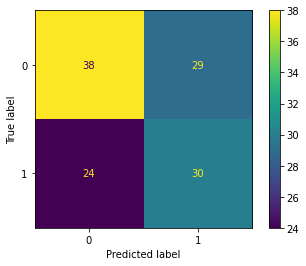

In [10]:
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [11]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5619834710743802
Precision: 0.5084745762711864
Recall: 0.5555555555555556


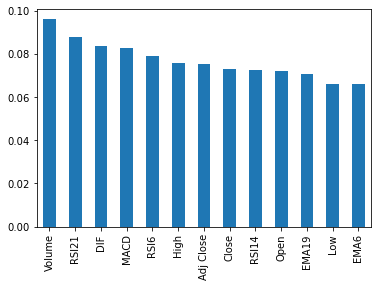

In [12]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();